# Assignment 2: DenseNet with CIFAR10 Dataset by TensorFlow

In this assignment, you are required to implement DenseNet to classify images from the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) by using TensorFlow with Keras. DenseNet is very well-known and therefore it has been implemented and pre-trained by Keras. You are also required to load and test the pre-trained models, and compare them with your models.

First of all, read the DenseNet paper. DenseNet was originally proposed in 2016 by Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger in the following paper:
https://arxiv.org/abs/1608.06993

The process will be broken down into the following steps:
>
1. Answer a short question about DenseNet. (10 marks)
2. Load and visualize the data.
3. Implement your models. (30 marks)
4. Train and evaluate your models. (25 marks)
5. Load the pre-trained models from Keras and evaluate them. (15 marks)
6. Analysis your results. (20 marks)

---
## 1. Answer a short question (20 marks)

Now that you know what DenseNet is all about, let's compare it to VGG.
Both VGG and DenseNet papers describe several variations of their models that differ by their depth.
For example, VGG16 and VGG19, DenseNet-121 and DenseNet-169 are four examples from these papers.

Aside from difference in network depth, how is the architecture of DenseNet different from that of VGG? Please enter your answer in the next cell (approximately 100-200 words, both English and Chinese are acceptable).

**Write your answer in this cell.**
VGGNet的主要特点就是小卷积核和更深层次的网络，Densenet解决了深层的网络难以训练和梯度消失的问题，DenseNet基于与其多次学习冗余的特征,特征复用是一种更好的特征提取方式的假设.提出了一个激进的密集连接机制：即互相连接所有的层，具体来说就是每个层都会接受其前面所有层作为其额外的输入。这种直接concat来自不同层的特征图的方法，这可以实现特征重用，提升效率，但这种激进的做法也有显存占用高的缺点，但瑕不掩瑜，DenseNet缓解了梯度消失问题，加强了特征传播和特征复用，极大的减少了参数量。

---
## 2. Load and visualize the data.

The data is directly loaded into memory.

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

num_classes = 10

# load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions
input_shape = x_train.shape[1:]

# mormalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

2021-11-03 10:25:08.220251: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


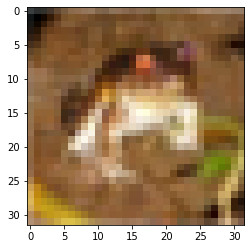

In [2]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

---
## 3. Implement your models (30 marks)

In this task, you are required to implement DenseNet-73 and DenseNet-93 with compression and bottleneck as depicted in the original paper. DenseNet-73 and DenseNet-93 follow the architecture of DenseNet and remove several convolution layers for time efficiency. Specifically, DenseNet-73 and DenseNet-93 have a group of 4 Dense Block, each has a set of [4,8,12,10] and [4,8,16,16] mini-block including a 1x1 conv follow by a 3x3 conv. For more details, please refer to Table 1 in the original paper.

In [3]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers


def conv_block(x, growth_rate, name):
    # axis的值取决于按照input的哪一个维度进行BN,
    x1 = layers.BatchNormalization(axis=3)(x)
    x1 = layers.LeakyReLU(alpha=0.2)(x1)
    # 第一个参数代表Filter/Kernel的个数，等于卷积后的输出通道数
    # 第二个位置代表卷积核尺寸，用两个整数的元组或者列表表示，用单个正数表示为所有的空间维度指定相同的值
    x1 = layers.Conv2D(2 * growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = layers.BatchNormalization(axis=3)(x1)
    x1 = layers.LeakyReLU(alpha=0.2, name=name + '_1_leakyRelu')(x1)
    x1 = layers.Conv2D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1)
    x = layers.Concatenate(name=name + '_concat')([x, x1])
    return x


def dense_block(x, blocks, name, growth_rate=32):
    for i in range(blocks):
        x = conv_block(x, growth_rate, name=name + '_block' + str(i + 1))
    return x


def transition_block(x, reduction, name):
    x = layers.BatchNormalization(axis=3, name=name + '_bn')(x)
    x = layers.LeakyReLU(alpha=0.2, name=name + '_leakyRelu')(x)
    x = layers.Conv2D(int(x.shape[3] * reduction), 1, use_bias=False, name=name + '_conv')(x)
    # pool_size：一个整数或者2个整数的元组/列表：（pool_height，pool_width）
    # 指定池化窗口的大小。 可以是单个整数，以为所有空间维度指定相同值
    # strides：一个整数或者2个整数的元组 / 列表
    # 指定池操作的步幅。 可以是单个整数，以为所有空间维度指定相同值
    x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x


def my_densenet(blocks):
    inputs = keras.Input(shape=(32, 32, 3), name='img')
    x = layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = dense_block(x, blocks[0], name='conv1', growth_rate=32)
    x = transition_block(x, 0.5, name='pool1')
    x = dense_block(x, blocks[1], name='conv2', growth_rate=32)
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, blocks[2], name='conv3', growth_rate=32)
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, blocks[3], name='conv4', growth_rate=32)
    x = layers.BatchNormalization(axis=3, name='bn')(x)
    x = layers.LeakyReLU(alpha=0.2, name='leakyRelu')(x)
    x = layers.GlobalAvgPool2D(name='avg_pool')(x)
    x = layers.Dense(10, activation='softmax', name='fc')(x)
    model = keras.Model(inputs, x, name='densenet_73')
    return model


def my_model(blocks=(4, 8, 12, 10)):
    denseNet = my_densenet(blocks)
    denseNet.compile(optimizer=keras.optimizers.Adam(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
    denseNet.summary()
    return denseNet

In [4]:
# implement the code of your DenseNet-73 model here.
model_73 = my_model((4, 8, 12, 10))

2021-11-03 10:25:11.149807: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-03 10:25:11.150698: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-03 10:25:12.536959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-03 10:25:12.538445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:82:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-03 10:25:12.538489: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-

Model: "densenet_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         img[0][0]                        
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          leaky_re_lu[0][0]                
________________________________________________________________________________________

In [5]:
# implement the code of your DenseNet-93 model here.
model_93 = my_model((4, 8, 16, 16))

Model: "densenet_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         img[0][0]                        
__________________________________________________________________________________________________
leaky_re_lu_35 (LeakyReLU)      (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 32, 32, 16)   64          leaky_re_lu_35[0][0]             
________________________________________________________________________________________

---
## 4. Train and evaluate your models. (25 marks)

### 4.1 Train your models. (20 marks)

In [6]:
# implement your code here.
epochs = 100
for epoch in range(epochs):
    print('epoch:', epoch + 1)
    model_73.fit(x_train, y_train, batch_size=100, epochs=1, verbose=1)

for epoch in range(epochs):
    print('epoch:', epoch + 1)
    model_93.fit(x_train, y_train, batch_size=100, epochs=1, verbose=1)

epoch: 1


2021-11-03 10:25:17.893283: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-03 10:25:17.894199: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400085000 Hz
2021-11-03 10:25:23.620459: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-03 10:25:23.822211: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


500/500 [==============================] - 40s 64ms/step - loss: 1.4684 - accuracy: 0.4657
epoch: 2
500/500 [==============================] - 32s 64ms/step - loss: 0.7418 - accuracy: 0.7365
epoch: 3
500/500 [==============================] - 32s 64ms/step - loss: 0.5789 - accuracy: 0.7983
epoch: 4
500/500 [==============================] - 32s 64ms/step - loss: 0.4867 - accuracy: 0.8298
epoch: 5
500/500 [==============================] - 32s 64ms/step - loss: 0.4173 - accuracy: 0.8550
epoch: 6
500/500 [==============================] - 32s 64ms/step - loss: 0.3598 - accuracy: 0.8753
epoch: 7
500/500 [==============================] - 32s 63ms/step - loss: 0.3144 - accuracy: 0.8908
epoch: 8
500/500 [==============================] - 32s 63ms/step - loss: 0.2696 - accuracy: 0.9058
epoch: 9
500/500 [==============================] - 31s 63ms/step - loss: 0.2334 - accuracy: 0.9195
epoch: 10
500/500 [==============================] - 32s 64ms/step - loss: 0.2024 - accuracy: 0.9292
epoch: 1

500/500 [==============================] - 31s 62ms/step - loss: 0.0185 - accuracy: 0.9941
epoch: 83
500/500 [==============================] - 31s 63ms/step - loss: 0.0164 - accuracy: 0.9940
epoch: 84
500/500 [==============================] - 31s 62ms/step - loss: 0.0068 - accuracy: 0.9980
epoch: 85
500/500 [==============================] - 31s 62ms/step - loss: 0.0163 - accuracy: 0.9944
epoch: 86
500/500 [==============================] - 31s 62ms/step - loss: 0.0170 - accuracy: 0.9942
epoch: 87
500/500 [==============================] - 31s 62ms/step - loss: 0.0088 - accuracy: 0.9972
epoch: 88
500/500 [==============================] - 31s 62ms/step - loss: 0.0086 - accuracy: 0.9971
epoch: 89
500/500 [==============================] - 31s 62ms/step - loss: 0.0149 - accuracy: 0.9949
epoch: 90
500/500 [==============================] - 31s 62ms/step - loss: 0.0102 - accuracy: 0.9968
epoch: 91
500/500 [==============================] - 31s 62ms/step - loss: 0.0069 - accuracy: 0.9976


500/500 [==============================] - 37s 73ms/step - loss: 0.0146 - accuracy: 0.9949
epoch: 64
500/500 [==============================] - 37s 74ms/step - loss: 0.0170 - accuracy: 0.9943
epoch: 65
500/500 [==============================] - 37s 74ms/step - loss: 0.0196 - accuracy: 0.9931
epoch: 66
500/500 [==============================] - 36s 73ms/step - loss: 0.0164 - accuracy: 0.9945
epoch: 67
500/500 [==============================] - 36s 73ms/step - loss: 0.0145 - accuracy: 0.9952
epoch: 68
500/500 [==============================] - 36s 73ms/step - loss: 0.0173 - accuracy: 0.9940
epoch: 69
500/500 [==============================] - 37s 73ms/step - loss: 0.0193 - accuracy: 0.9938
epoch: 70
500/500 [==============================] - 37s 73ms/step - loss: 0.0078 - accuracy: 0.9974
epoch: 71
500/500 [==============================] - 37s 73ms/step - loss: 0.0180 - accuracy: 0.9938
epoch: 72
500/500 [==============================] - 36s 73ms/step - loss: 0.0175 - accuracy: 0.9938


### 4.2 Test your models. (5 marks)

In [7]:
# implement your code here.
res = model_73.evaluate(x_test, y_test, verbose=1)
print('model_73-loss:', str(res[0]), 'model_73-acc:', str(res[1]))
res = model_93.evaluate(x_test, y_test, verbose=1)
print('model_93-loss:', str(res[0]), 'model_93-acc:', str(res[1]))

313/313 [==============================] - 7s 17ms/step - loss: 0.8490 - accuracy: 0.8665
model_73-loss: 0.8490239977836609 model_73-acc: 0.8665000200271606
313/313 [==============================] - 8s 21ms/step - loss: 0.8141 - accuracy: 0.8759
model_93-loss: 0.8140944838523865 model_93-acc: 0.8758999705314636


---
## 5. Load the pre-trained models from Keras and evaluate them. (15 marks)

Use the pre-trained DenseNet-121 model from keras and fine-tune them by adding a few fc layers at the end. You should set the parameter weights='imagenet', rather than None, to use the pretrained weights.

In [8]:
from tensorflow.keras.applications.densenet import DenseNet121

# implement your code here.
# 构建不带分类器的预训练模型
base_model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# 添加全局平均池化层
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# 添加一个分类器，我们有10个类
predictions = layers.Dense(10, activation='softmax')(x)
# 构建我们需要训练的完整模型
pre_trained_model = keras.Model(inputs=base_model.input, outputs=predictions)

# 首先，我们只训练顶部的几层（随机初始化的层）
# 锁住所有 base_model 的卷积层
for layer in base_model.layers:
    layer.trainable = False

# 编译模型（一定要在锁层以后操作）
pre_trained_model.compile(optimizer=keras.optimizers.Adam(),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
epochs = 50
for epoch in range(epochs):
    print('epoch:', epoch + 1)
    pre_trained_model.fit(x_train, y_train, batch_size=100, epochs=1, verbose=1)

for layer in base_model.layers:
    layer.trainable = True

# 让我们设置一个很低的学习率，使用 Adam 来微调
pre_trained_model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
for epoch in range(epochs):
    print('epoch:', epoch + 1)
    pre_trained_model.fit(x_train, y_train, batch_size=100, epochs=1, verbose=1)
res = pre_trained_model.evaluate(x_test, y_test, verbose=1)
print('pre_trained_model-loss:', str(res[0]), 'pre_trained_model-acc:', str(res[1]))

epoch: 1
500/500 [==============================] - 16s 22ms/step - loss: 1.7543 - accuracy: 0.4048
epoch: 2
500/500 [==============================] - 11s 22ms/step - loss: 1.1328 - accuracy: 0.6085
epoch: 3
500/500 [==============================] - 11s 22ms/step - loss: 1.0749 - accuracy: 0.6283
epoch: 4
500/500 [==============================] - 11s 22ms/step - loss: 1.0469 - accuracy: 0.6358
epoch: 5
500/500 [==============================] - 11s 22ms/step - loss: 1.0308 - accuracy: 0.6418
epoch: 6
500/500 [==============================] - 11s 22ms/step - loss: 1.0171 - accuracy: 0.6472
epoch: 7
500/500 [==============================] - 11s 22ms/step - loss: 1.0089 - accuracy: 0.6489
epoch: 8
500/500 [==============================] - 11s 22ms/step - loss: 1.0029 - accuracy: 0.6499
epoch: 9
500/500 [==============================] - 11s 22ms/step - loss: 0.9950 - accuracy: 0.6541
epoch: 10
500/500 [==============================] - 11s 22ms/step - loss: 0.9911 - accuracy: 0.6543

500/500 [==============================] - 36s 71ms/step - loss: 0.0356 - accuracy: 0.9880
epoch: 33
500/500 [==============================] - 35s 71ms/step - loss: 0.0321 - accuracy: 0.9895
epoch: 34
500/500 [==============================] - 36s 71ms/step - loss: 0.0144 - accuracy: 0.9950
epoch: 35
500/500 [==============================] - 36s 72ms/step - loss: 0.0147 - accuracy: 0.9951
epoch: 36
500/500 [==============================] - 36s 72ms/step - loss: 0.0173 - accuracy: 0.9942
epoch: 37
500/500 [==============================] - 35s 71ms/step - loss: 0.0169 - accuracy: 0.9943
epoch: 38
500/500 [==============================] - 36s 72ms/step - loss: 0.0218 - accuracy: 0.9928
epoch: 39
500/500 [==============================] - 36s 72ms/step - loss: 0.0195 - accuracy: 0.9935
epoch: 40
500/500 [==============================] - 36s 72ms/step - loss: 0.0144 - accuracy: 0.9954
epoch: 41
500/500 [==============================] - 35s 70ms/step - loss: 0.0191 - accuracy: 0.9937


---
## 6. Analysis your results. (20 marks)
Compare the performance of your models with the following analysis. Both English and Chinese answers are acceptable.
1. Is your implementation of DenseNet-93 better than DenseNet-73? If yes, how is the improvement? If no, try to figure the reason out based on your experiments. (10 marks)

Answer:

2. Compare the results of your implementations with the pre-trained DenseNet-121 models from Keras. (10 marks)

Answer:



1、在第一次训练中，我将epoch设置为10，在10个epoch的训练过程中，DenseNet-93并没有取得比DenseNet-73更好的结果，结果如下所示：

313/313 [==============================] - 7s 18ms/step - loss: 0.5753 - accuracy: 0.8261

model_73-loss: 0.5752847194671631 model_73-acc: 0.8260999917984009

313/313 [==============================] - 8s 21ms/step - loss: 0.6818 - accuracy: 0.8069

model_93-loss: 0.6818189024925232 model_93-acc: 0.8069000244140625

我认为是更深层次的网络可能更加难以训练，所以，我将训练的epoch调整到了100，果然效果有了出色的提升：

313/313 [==============================] - 7s 17ms/step - loss: 0.8490 - accuracy: 0.8665

model_73-loss: 0.8490239977836609 model_73-acc: 0.8665000200271606

313/313 [==============================] - 8s 21ms/step - loss: 0.8141 - accuracy: 0.8759

model_93-loss: 0.8140944838523865 model_93-acc: 0.8758999705314636

在100个epoch的训练中，DenseNet-93在测试集上达到了87.6%的精确度，比DenseNet-73的86.6%的效果要好。但总体来说，效果差距并不大。

说明低层的DenseNet在这个任务上已经能够取得很好的效果。

2、在使用pre-trained DenseNet-121的过程中，我首先构建了不带分类器的DenseNet-121模型，然后增加了pooling层和softmax层，首先对原来的DenseNet模型进行锁定参数的操作，使用5个epoch对随机的参数进行调整，然后取消锁定，使用5个epoch对所有参数进行了调整，得到的结果如下：

pre_trained_model-loss: 0.6386442184448242 pre_trained_model-acc: 0.8180000185966492

可以看到，效果和我们自己实现的模型相近，我刚开始认为是训练次数不够导致的：

然后对原来的DenseNet模型进行锁定参数的操作，使用50个epoch对随机的参数进行调整，然后取消锁定，使用50个epoch对所有参数进行了调整，得到的结果如下：

pre_trained_model-loss: 0.8333893418312073 pre_trained_model-acc: 0.857200026512146

可以看到，效果还不如自己实现的enseNet-93和DenseNet-73，我认为是在模型的调参上和一些trick上，自己实现的模型在这个任务上更出色。